## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import pickle
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

## Prepare data for model training

In [2]:
with open("../input/he-pgd-turkey-ham/MathCoThon_Ready_Sandwich.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

20

In [3]:
cat_cols = [
 'Inherited from father',
 'Maternal gene',
 'Respiratory Rate (breaths/min)',
 'Heart Rate (rates/min',
 'Follow-up',
 'Gender',
 'Birth asphyxia',
 'Autopsy shows birth defect (if applicable)',
 'Place of birth',
 'Folic acid details (peri-conceptional)',
 'H/O serious maternal illness',
 'H/O radiation exposure (x-ray)',
 'H/O substance abuse',
 'Assisted conception IVF/ART',
 'History of anomalies in previous pregnancies',
 'Birth defects',
 'Blood test result',
 'Institute Name',
 'Institute Addr',
 'Institute Zipcode',
 'No. of previous abortion'
]

train_df[cat_cols] = train_df[cat_cols].astype(int)
test_df[cat_cols] = test_df[cat_cols].astype(int)

for col in tqdm(cat_cols):
    dummy_val = pd.get_dummies(train_df[col], prefix=col)
    train_df = pd.concat([train_df, dummy_val], axis=1)
    train_df.drop([col], inplace=True, axis=1)

print("train_df: {}".format(train_df.shape))

for col in tqdm(cat_cols):
    dummy_val = pd.get_dummies(test_df[col], prefix=col)
    test_df = pd.concat([test_df, dummy_val], axis=1)
    test_df.drop([col], inplace=True, axis=1)

print("test_df: {}".format(test_df.shape))

  5%|▍         | 1/21 [00:00<00:02,  8.11it/s]

train_df: (18047, 1101)


100%|██████████| 21/21 [00:02<00:00,  8.16it/s]

test_df: (9465, 1100)


In [4]:
Xtrain = train_df.loc[:, ~train_df.columns.isin(['target'])].copy()
Ytrain = train_df['target'].copy()
Xtest = test_df.copy()

print(f"Xtrain: {Xtrain.shape} \nYtrain: {Ytrain.shape} \nXtest: {Xtest.shape}")

del train_df
del test_df
gc.collect()

Xtrain: (18047, 1100) 
Ytrain: (18047,) 
Xtest: (9465, 1100)


72

## Build and validate the model

In [5]:
FOLD = 10
SEEDS = [2020, 2022]

fet_imp = 0
counter = 0
oof_score = 0
y_pred_meta_xgb = np.zeros((Xtrain.shape[0], 9))
y_pred_final_xgb = 0


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain.values, Ytrain)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = XGBClassifier(
            objective='multi:softmax',
            eval_metric='mlogloss',
            booster='gbtree',
            sample_type='weighted',
            tree_method='gpu_hist',
            grow_policy='lossguide',
            use_label_encoder=False,
            num_round=5000,
            num_class=3,
            max_depth=15, 
            max_leaves=512,
            learning_rate=0.05,
            subsample=0.75,
            colsample_bytree=0.95,
            min_child_weight=3,
            reg_lambda=0.01,
            verbosity=0,
            random_state=(seed+idx)
        )

        model.fit(train_x, train_y, eval_set=[(train_x, train_y),(val_x, val_y)], 
                  early_stopping_rounds=200, verbose=50)

        y_pred = model.predict_proba(val_x, iteration_range=(0, model.best_iteration))
        y_pred_meta_xgb[val] += y_pred
        y_pred_final_xgb += model.predict_proba(Xtest, iteration_range=(0, model.best_iteration))
        
        y_pred = np.array([np.argmax(y_pred, axis=1)]).T
        score = 100 * f1_score(val_y, y_pred, average='macro')
        oof_score += score
        seed_score += score
        fet_imp += model.feature_importances_
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_xgb = y_pred_meta_xgb / float(len(SEEDS))
y_pred_final_xgb = y_pred_final_xgb / float(counter)
fet_imp = fet_imp / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

[0]	validation_0-mlogloss:2.12984	validation_1-mlogloss:2.15897
[50]	validation_0-mlogloss:0.77845	validation_1-mlogloss:1.54999
[99]	validation_0-mlogloss:0.40653	validation_1-mlogloss:1.46354
Seed-2020 | Fold-0 | OOF Score: 28.065249425955972
[0]	validation_0-mlogloss:2.12748	validation_1-mlogloss:2.15740
[50]	validation_0-mlogloss:0.76573	validation_1-mlogloss:1.54445
[99]	validation_0-mlogloss:0.39990	validation_1-mlogloss:1.46428
Seed-2020 | Fold-1 | OOF Score: 24.746943541124267
[0]	validation_0-mlogloss:2.12882	validation_1-mlogloss:2.15786
[50]	validation_0-mlogloss:0.76363	validation_1-mlogloss:1.54938
[99]	validation_0-mlogloss:0.39768	validation_1-mlogloss:1.47459
Seed-2020 | Fold-2 | OOF Score: 27.374520696585225
[0]	validation_0-mlogloss:2.12932	validation_1-mlogloss:2.15727
[50]	validation_0-mlogloss:0.76336	validation_1-mlogloss:1.53763
[99]	validation_0-mlogloss:0.39850	validation_1-mlogloss:1.45310
Seed-2020 | Fold-3 | OOF Score: 25.94068310921005
[0]	validation_0-mlog

In [6]:
np.savez_compressed('./XGB_Meta_Features.npz',
                    y_pred_meta_xgb=y_pred_meta_xgb, 
                    oof_score=oof_score,
                    y_pred_final_xgb=y_pred_final_xgb)

## Create submission file

In [7]:
test_df = pd.read_csv("../input/predict-generic-disorder/dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['Patient Id'] = test_df['Patient Id']
submit_df['target'] = np.array([np.argmax(y_pred_final_xgb, axis=1)]).T

submit_df['target'] = submit_df['target'].map({
    0: "Mitochondrial genetic inheritance disorders//Leber's hereditary optic neuropathy",
    1: 'Mitochondrial genetic inheritance disorders//Leigh syndrome',
    2: 'Mitochondrial genetic inheritance disorders//Mitochondrial myopathy',
    3: "Multifactorial genetic inheritance disorders//Alzheimer's",
    4: 'Multifactorial genetic inheritance disorders//Cancer',
    5: 'Multifactorial genetic inheritance disorders//Diabetes',
    6: 'Single-gene inheritance diseases//Cystic fibrosis',
    7: 'Single-gene inheritance diseases//Hemochromatosis',
    8: 'Single-gene inheritance diseases//Tay-Sachs'
})

submit_df.groupby(['target']).size().reset_index().rename(columns={0:'Count'})

,target,Count
0,Mitochondrial genetic inheritance disorders//L...,72
1,Mitochondrial genetic inheritance disorders//L...,3420
2,Mitochondrial genetic inheritance disorders//M...,1599
3,Multifactorial genetic inheritance disorders//...,9
4,Multifactorial genetic inheritance disorders//...,1
5,Multifactorial genetic inheritance disorders//...,694
6,Single-gene inheritance diseases//Cystic fibrosis,2763
7,Single-gene inheritance diseases//Hemochromatosis,197
8,Single-gene inheritance diseases//Tay-Sachs,710


In [8]:
submit_df['Genetic Disorder'] = submit_df['target'].apply(lambda x: x.split('//')[0])
submit_df['Disorder Subclass'] = submit_df['target'].apply(lambda x: x.split('//')[1])
submit_df.drop(['target'], axis=1, inplace=True)
submit_df.head()

,Patient Id,Genetic Disorder,Disorder Subclass
0,PID0x4175,Single-gene inheritance diseases,Cystic fibrosis
1,PID0x21f5,Single-gene inheritance diseases,Hemochromatosis
2,PID0x49b8,Single-gene inheritance diseases,Tay-Sachs
3,PID0x2d97,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x58da,Mitochondrial genetic inheritance disorders,Leigh syndrome


In [9]:
submit_df.to_csv("./XGB_Submission.csv", index=False)

## Classification Report

In [10]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Paired)
    plt.title('Confusion matrix', fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [11]:
y_pred = np.array([np.argmax(y_pred_meta_xgb, axis=1)]).T
print(classification_report(Ytrain, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.08      0.12       587
           1       0.38      0.47      0.42      4683
           2       0.34      0.35      0.35      3971
           3       0.14      0.02      0.04       133
           4       0.46      0.07      0.12        91
           5       0.35      0.26      0.30      1653
           6       0.40      0.52      0.45      3145
           7       0.39      0.24      0.30      1228
           8       0.34      0.26      0.29      2556

    accuracy                           0.37     18047
   macro avg       0.34      0.25      0.26     18047
weighted avg       0.36      0.37      0.36     18047



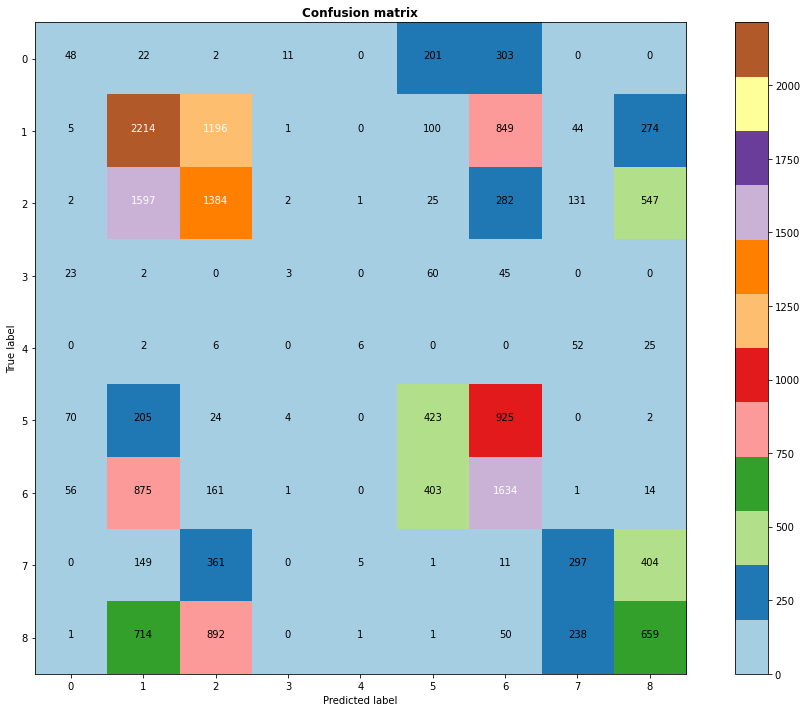

In [12]:
cnf_matrix = confusion_matrix(Ytrain, y_pred, labels=list(range(9)))
np.set_printoptions(precision=2)
plt.figure(figsize=(14,10))
plot_confusion_matrix(cnf_matrix, classes=list(range(9)))

## Features Importance

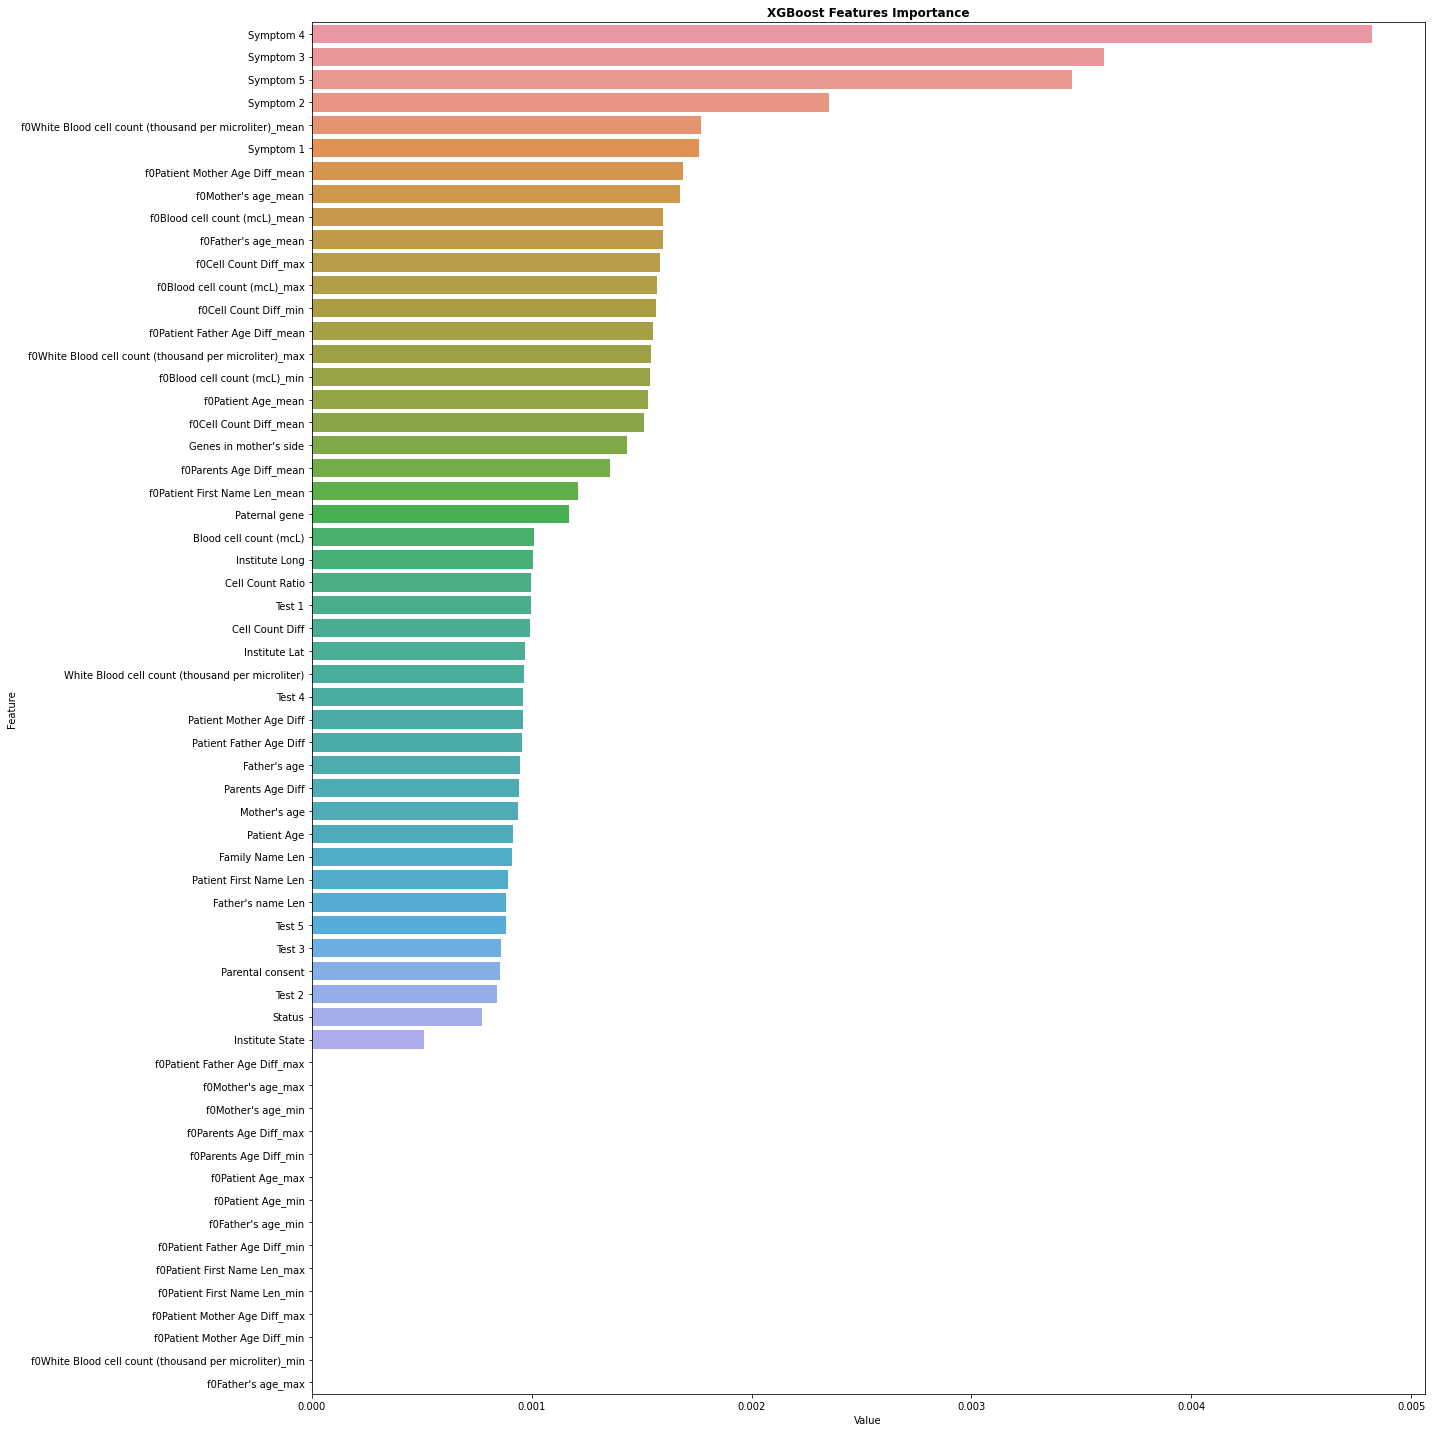

In [13]:
feature_imp = pd.DataFrame(sorted(zip(fet_imp[0:60], Xtrain.columns[0:60])), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features Importance', fontweight='bold')
plt.tight_layout()
plt.show()